In [75]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
customers_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

# Aggregate the engagements data
engagements_agg = engagements_df.groupby('customer_id').agg({
    'number_of_site_visits': 'sum',
    'number_of_emails_opened': 'sum',
    'number_of_clicks': 'sum'
}).reset_index()

# Aggregate the marketing data
marketing_agg = marketing_df.groupby('customer_id').agg({
    'campaign_id': 'count',
    'response': lambda x: (x == 'Yes').sum()  # Count of positive responses
}).reset_index().rename(columns={'campaign_id': 'number_of_campaigns', 'response': 'positive_responses'})

# Aggregate the transactions data
transactions_agg = transactions_df.groupby('customer_id').agg({
    'transaction_id': 'count',
    'transaction_amount': 'sum'
}).reset_index().rename(columns={'transaction_id': 'number_of_transactions', 'transaction_amount': 'total_spent'})

# Merge the aggregated datasets with the customer data
merged_df = customers_df.merge(engagements_agg, on='customer_id', how='left')
merged_df = merged_df.merge(marketing_agg, on='customer_id', how='left')
merged_df = merged_df.merge(transactions_agg, on='customer_id', how='left')

# Count missing values per column
missing_values = merged_df.isnull().sum()

# Display the merged dataset
merged_df.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,number_of_campaigns,positive_responses,number_of_transactions,total_spent
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,1,6,3509.48
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,4,2,9,6081.32
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,2,1,6,1454.87
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,4,1,20,7874.68
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,4,0,24,15524.55


In [76]:
merged_df.describe()

,customer_id,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,number_of_campaigns,positive_responses,number_of_transactions,total_spent
count,10000.00000,8991.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,43.467467,100.111900,39.862100,19.725300,2.520000,1.257800,12.954500,7737.562981
std,2886.89568,15.094380,118.625052,46.511719,22.975083,1.111721,0.971511,7.191203,4628.799469
min,1.00000,18.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,23.810000
25%,2500.75000,30.000000,15.000000,6.000000,3.000000,2.000000,1.000000,7.000000,3839.915000
50%,5000.50000,44.000000,53.000000,22.000000,11.000000,3.000000,1.000000,13.000000,7498.890000
75%,7500.25000,57.000000,141.000000,57.000000,28.000000,4.000000,2.000000,19.000000,11275.797500
max,10000.00000,69.000000,711.000000,303.000000,142.000000,4.000000,4.000000,25.000000,24298.220000


In [77]:
# Count missing values per column
missing_values = merged_df.isnull().sum()
missing_values

customer_id                   0
join_date                     0
last_purchase_date            0
age                        1009
gender                      533
location                      0
number_of_site_visits         0
number_of_emails_opened       0
number_of_clicks              0
number_of_campaigns           0
positive_responses            0
number_of_transactions        0
total_spent                   0
dtype: int64

In [78]:

# Data Cleaning
# Convert date columns to datetime
customers_df['join_date'] = pd.to_datetime(customers_df['join_date'])
customers_df['last_purchase_date'] = pd.to_datetime(customers_df['last_purchase_date'])
marketing_df['campaign_date'] = pd.to_datetime(marketing_df['campaign_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

# Convert dates later than 7/17/2024 to 7/17/2024
cutoff_date = pd.Timestamp('2024-07-17')
customers_df['join_date'] = customers_df['join_date'].apply(lambda x: min(x, cutoff_date))
customers_df['last_purchase_date'] = customers_df['last_purchase_date'].apply(lambda x: min(x, cutoff_date))
marketing_df['campaign_date'] = marketing_df['campaign_date'].apply(lambda x: min(x, cutoff_date))
transactions_df['transaction_date'] = transactions_df['transaction_date'].apply(lambda x: min(x, cutoff_date))

# Impute 'unknown' for missing gender values
customers_df['gender'].fillna('unknown', inplace=True)

# Impute missing values in the Customers dataset using KNN for 'age'
imputer = KNNImputer(n_neighbors=5)
customers_df[['age']] = imputer.fit_transform(customers_df[['age']])

# Feature Engineering
# Calculate Recency, Frequency, and Monetary Value (RFM) features
cutoff_date = pd.Timestamp('2024-07-17')
rfm = transactions_df.groupby('customer_id').agg({
    'transaction_date': lambda x: (cutoff_date - x.max()).days,
    'transaction_id': 'count',
    'transaction_amount': 'sum'
}).reset_index()
rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Calculate the number of months from join date to last purchase date
customers_df['months_since_join'] = (customers_df['last_purchase_date'] - customers_df['join_date']).dt.days / 30
customers_df['months_since_join'].replace(0, 1, inplace=True)  # Avoid division by zero
customers_df['months_since_join'] = customers_df['months_since_join'].apply(lambda x: x if x > 1 else 1)

# Define CLV using the new formula
rfm['clv'] = rfm['monetary'] / customers_df['months_since_join']

# Merge RFM data with Customers data
merged_df = customers_df.merge(rfm, on='customer_id', how='left')

# Merge with Engagements data
merged_df = merged_df.merge(engagements_df, on='customer_id', how='left')

# Calculate the number of total responses to marketing campaigns
total_responses = marketing_df.groupby('customer_id').size().reset_index(name='total_responses')

# Merge with the Marketing data
merged_df = merged_df.merge(total_responses, on='customer_id', how='left')
merged_df['total_responses'].fillna(0, inplace=True)

# Calculate the number of positive responses to marketing campaigns
positive_responses_count = marketing_df[marketing_df['response'] == 'Yes'].groupby('customer_id').size().reset_index(name='positive_responses')

# Merge with the positive responses data
merged_df = merged_df.merge(positive_responses_count, on='customer_id', how='left')
merged_df['positive_responses'].fillna(0, inplace=True)

# Feature Engineering for Engagements
# Replace 0 with 1 to avoid division by zero in frequency
merged_df['frequency'].replace(0, 1, inplace=True)

# Calculate positive responses per transaction, emails opened per transaction, clicks per transaction, and site visits per transaction
merged_df['positive_responses_per_transaction'] = merged_df['positive_responses'] / merged_df['frequency']
merged_df['emails_opened_per_transaction'] = merged_df['number_of_emails_opened'] / merged_df['frequency']
merged_df['clicks_per_transaction'] = merged_df['number_of_clicks'] / merged_df['frequency']
merged_df['site_visits_per_transaction'] = merged_df['number_of_site_visits'] / merged_df['frequency']

# Replace any remaining infinite values with NaN and drop rows with NaN in features
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(subset=['positive_responses_per_transaction', 'emails_opened_per_transaction', 'clicks_per_transaction', 'site_visits_per_transaction'], inplace=True)

# Sort customers by CLV and calculate cumulative CLV
merged_df = merged_df.sort_values(by='clv', ascending=False)
merged_df['cumulative_clv'] = merged_df['clv'].cumsum()
total_clv = merged_df['clv'].sum()

# Label customers as 'high value' or 'low value'
merged_df['CLV_label'] = np.where(merged_df['cumulative_clv'] <= 0.8 * total_clv, 'High Value', 'Low Value')

# Convert CLV_label to binary
merged_df['CLV_label'] = np.where(merged_df['CLV_label'] == 'High Value', 1, 0)

C:\Users\NeilXu\AppData\Local\Temp\ipykernel_20876\1432802865.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers_df['gender'].fillna('unknown', inplace=True)
C:\Users\NeilXu\AppData\Local\Temp\ipykernel_20876\1432802865.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [94]:
merged_df.head()

,customer_id,join_date,last_purchase_date,age,gender,location,months_since_join,recency,frequency,monetary,...,number_of_clicks,total_responses,positive_responses,positive_responses_per_transaction,emails_opened_per_transaction,clicks_per_transaction,site_visits_per_transaction,cumulative_clv,CLV_label,age_group
7015,7016,2024-05-14,2024-05-28,45.0,unknown,West Karifort,1.0,51,25,22364.72,...,1,1,0.0,0.000000,0.040000,0.040000,0.24,22364.72,1,40-60
6632,6633,2024-05-25,2024-05-28,54.0,Male,Anthonymouth,1.0,51,25,21518.15,...,1,3,0.0,0.000000,0.040000,0.040000,0.04,43882.87,1,40-60
7583,7584,2024-04-20,2024-05-12,24.0,Female,Elizabethton,1.0,67,25,21056.06,...,1,2,1.0,0.040000,0.040000,0.040000,0.04,64938.93,1,20-40
3822,3823,2022-11-29,2022-12-29,60.0,Male,Monicaburgh,1.0,569,22,20601.69,...,2,4,3.0,0.136364,0.045455,0.090909,0.50,85540.62,1,>60
1916,1917,2024-01-01,2024-01-01,28.0,Male,South Crystalland,1.0,198,25,19876.28,...,1,2,1.0,0.040000,0.040000,0.040000,0.04,105416.90,1,20-40


In [95]:
merged_df.describe()

,customer_id,join_date,last_purchase_date,age,months_since_join,recency,frequency,monetary,clv,number_of_site_visits,number_of_emails_opened,number_of_clicks,total_responses,positive_responses,positive_responses_per_transaction,emails_opened_per_transaction,clicks_per_transaction,site_visits_per_transaction,cumulative_clv,CLV_label
count,10000.00000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,5000.50000,2022-03-19 09:28:13.440000,2023-04-25 18:26:12.480000256,43.467467,13.463457,496.256600,12.954500,7737.562981,1878.661528,100.111900,39.862100,19.725300,2.520000,1.257800,0.192833,6.300875,3.092276,15.944076,1.559754e+07,0.284500
min,1.00000,2020-01-01 00:00:00,2020-01-26 00:00:00,18.000000,1.000000,47.000000,1.000000,23.810000,0.646425,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.040000,0.040000,0.040000,2.236472e+04,0.000000
25%,2500.75000,2021-02-15 00:00:00,2022-09-19 00:00:00,32.000000,3.600000,198.750000,7.000000,3839.915000,283.926954,15.000000,6.000000,3.000000,2.000000,1.000000,0.041667,0.526316,0.291667,1.320000,1.441134e+07,0.000000
50%,5000.50000,2022-03-19 00:00:00,2023-08-04 00:00:00,43.467467,10.000000,408.000000,13.000000,7498.890000,681.349923,53.000000,22.000000,11.000000,3.000000,1.000000,0.090909,2.000000,1.000000,4.848077,1.727724e+07,0.000000
75%,7500.25000,2023-04-28 00:00:00,2024-02-11 00:00:00,55.000000,20.600000,731.000000,19.000000,11275.797500,1959.550778,141.000000,57.000000,28.000000,4.000000,2.000000,0.187500,5.666667,2.764706,14.000000,1.842719e+07,1.000000
max,10000.00000,2024-05-31 00:00:00,2024-05-31 00:00:00,69.000000,52.766667,1634.000000,25.000000,24298.220000,22364.720000,711.000000,303.000000,142.000000,4.000000,4.000000,4.000000,298.000000,113.000000,684.000000,1.878662e+07,1.000000
std,2886.89568,NaN,NaN,14.312544,11.802484,359.683754,7.191203,4628.799469,2955.617056,118.625052,46.511719,22.975083,1.111721,0.971511,0.361048,15.256806,7.251774,39.410611,4.050177e+06,0.451199


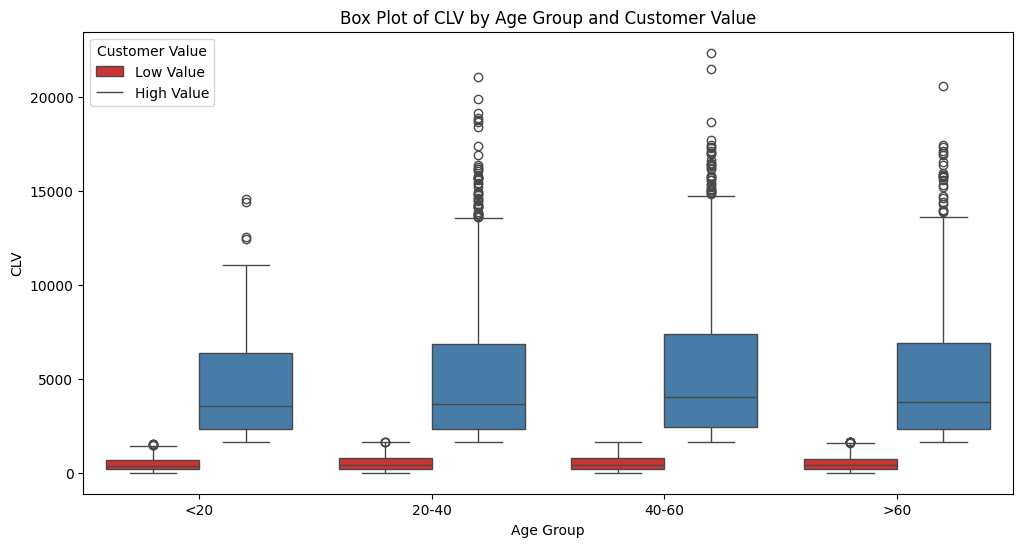

In [96]:
# Define age groups
age_bins = [0, 20, 40, 60, 100]
age_labels = ['<20', '20-40', '40-60', '>60']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=age_bins, labels=age_labels, right=False)

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='age_group', y='clv', hue='CLV_label', data=merged_df, palette='Set1')
plt.title('Box Plot of CLV by Age Group and Customer Value')
plt.xlabel('Age Group')
plt.ylabel('CLV')
plt.legend(title='Customer Value', labels=['Low Value', 'High Value'])
plt.show()

In [97]:
# Define age groups
age_bins = [0, 20, 40, 60, 100]
age_labels = ['<20', '20-40', '40-60', '>60']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=age_bins, labels=age_labels, right=False)

# Calculate mean, median, mode, and quantiles for CLV by age group and CLV label
clv_age_stats = merged_df.groupby(['age_group', 'CLV_label'])['clv'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])

# Calculate quantiles
quantiles = merged_df.groupby(['age_group', 'CLV_label'])['clv'].quantile([0.25, 0.5, 0.75]).unstack(level=-1)
quantiles.columns = ['25%', '50%', '75%']

# Combine the statistics
clv_age_stats = pd.concat([clv_stats, quantiles], axis=1)

C:\Users\NeilXu\AppData\Local\Temp\ipykernel_20876\3468840419.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clv_age_stats = merged_df.groupby(['age_group', 'CLV_label'])['clv'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
C:\Users\NeilXu\AppData\Local\Temp\ipykernel_20876\3468840419.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = merged_df.groupby(['age_group', 'CLV_label'])['clv'].quantile([0.25, 0.5, 0.75]).unstack(level=-1)


In [98]:
clv_age_stats

mean       median          std          min  \
age_group CLV_label                                                       
<20       0           489.285896   381.003130   389.311880     8.277021   
          1          4673.975214  3555.440164  3091.089839  1634.811885   
20-40     0           533.523659   431.276656   404.166871     1.381836   
          1          5174.083721  3672.401889  3757.003336  1632.680000   
40-60     0           524.220967   420.705705   401.604339     0.646425   
          1          5437.868578  4007.465192  3796.255960  1630.535484   
>60       0           518.763977   421.054516   394.858970     0.700156   
          1          5222.887463  3785.987413  3758.054021  1638.305017   

                              max  count          25%          50%  \
age_group CLV_label                                                  
<20       0           1550.652273    248   181.306082   381.003130   
          1          14570.150000     92  2337.627140  3555.440164   
20-40     0           1629.926425   2495   213.990400   431.276656   
          1          21056.060000    986  2343.012054  3672.401889   
40-60     0           1622.253020   3191   199.121915   420.705705   
          1          22364.720000   1244  2459.439000  4007.465192   
>60       0           1630.261943   1221   198.026627   421.054516   
          1          20601.690000    523  2327.300175  3785.987413   

                             75%          25%          50%          75%  
age_group CLV_label                                                      
<20       0           692.446800   181.306082   381.003130   692.446800  
          1          6364.895204  2337.627140  3555.440164  6364.895204  
20-40     0           778.201398   213.990400   431.276656   778.201398  
          1          6841.622500  2343.012054  3672.401889  6841.622500  
40-60     0           771.232505   199.121915   420.705705   771.232505  
          1          7391.270236  2459.439000  4007.465192  7391.270236  
>60       0           756.082353   198.026627   421.054516   756.082353  
          1          6882.674627  2327.300175  3785.987413  6882.674627

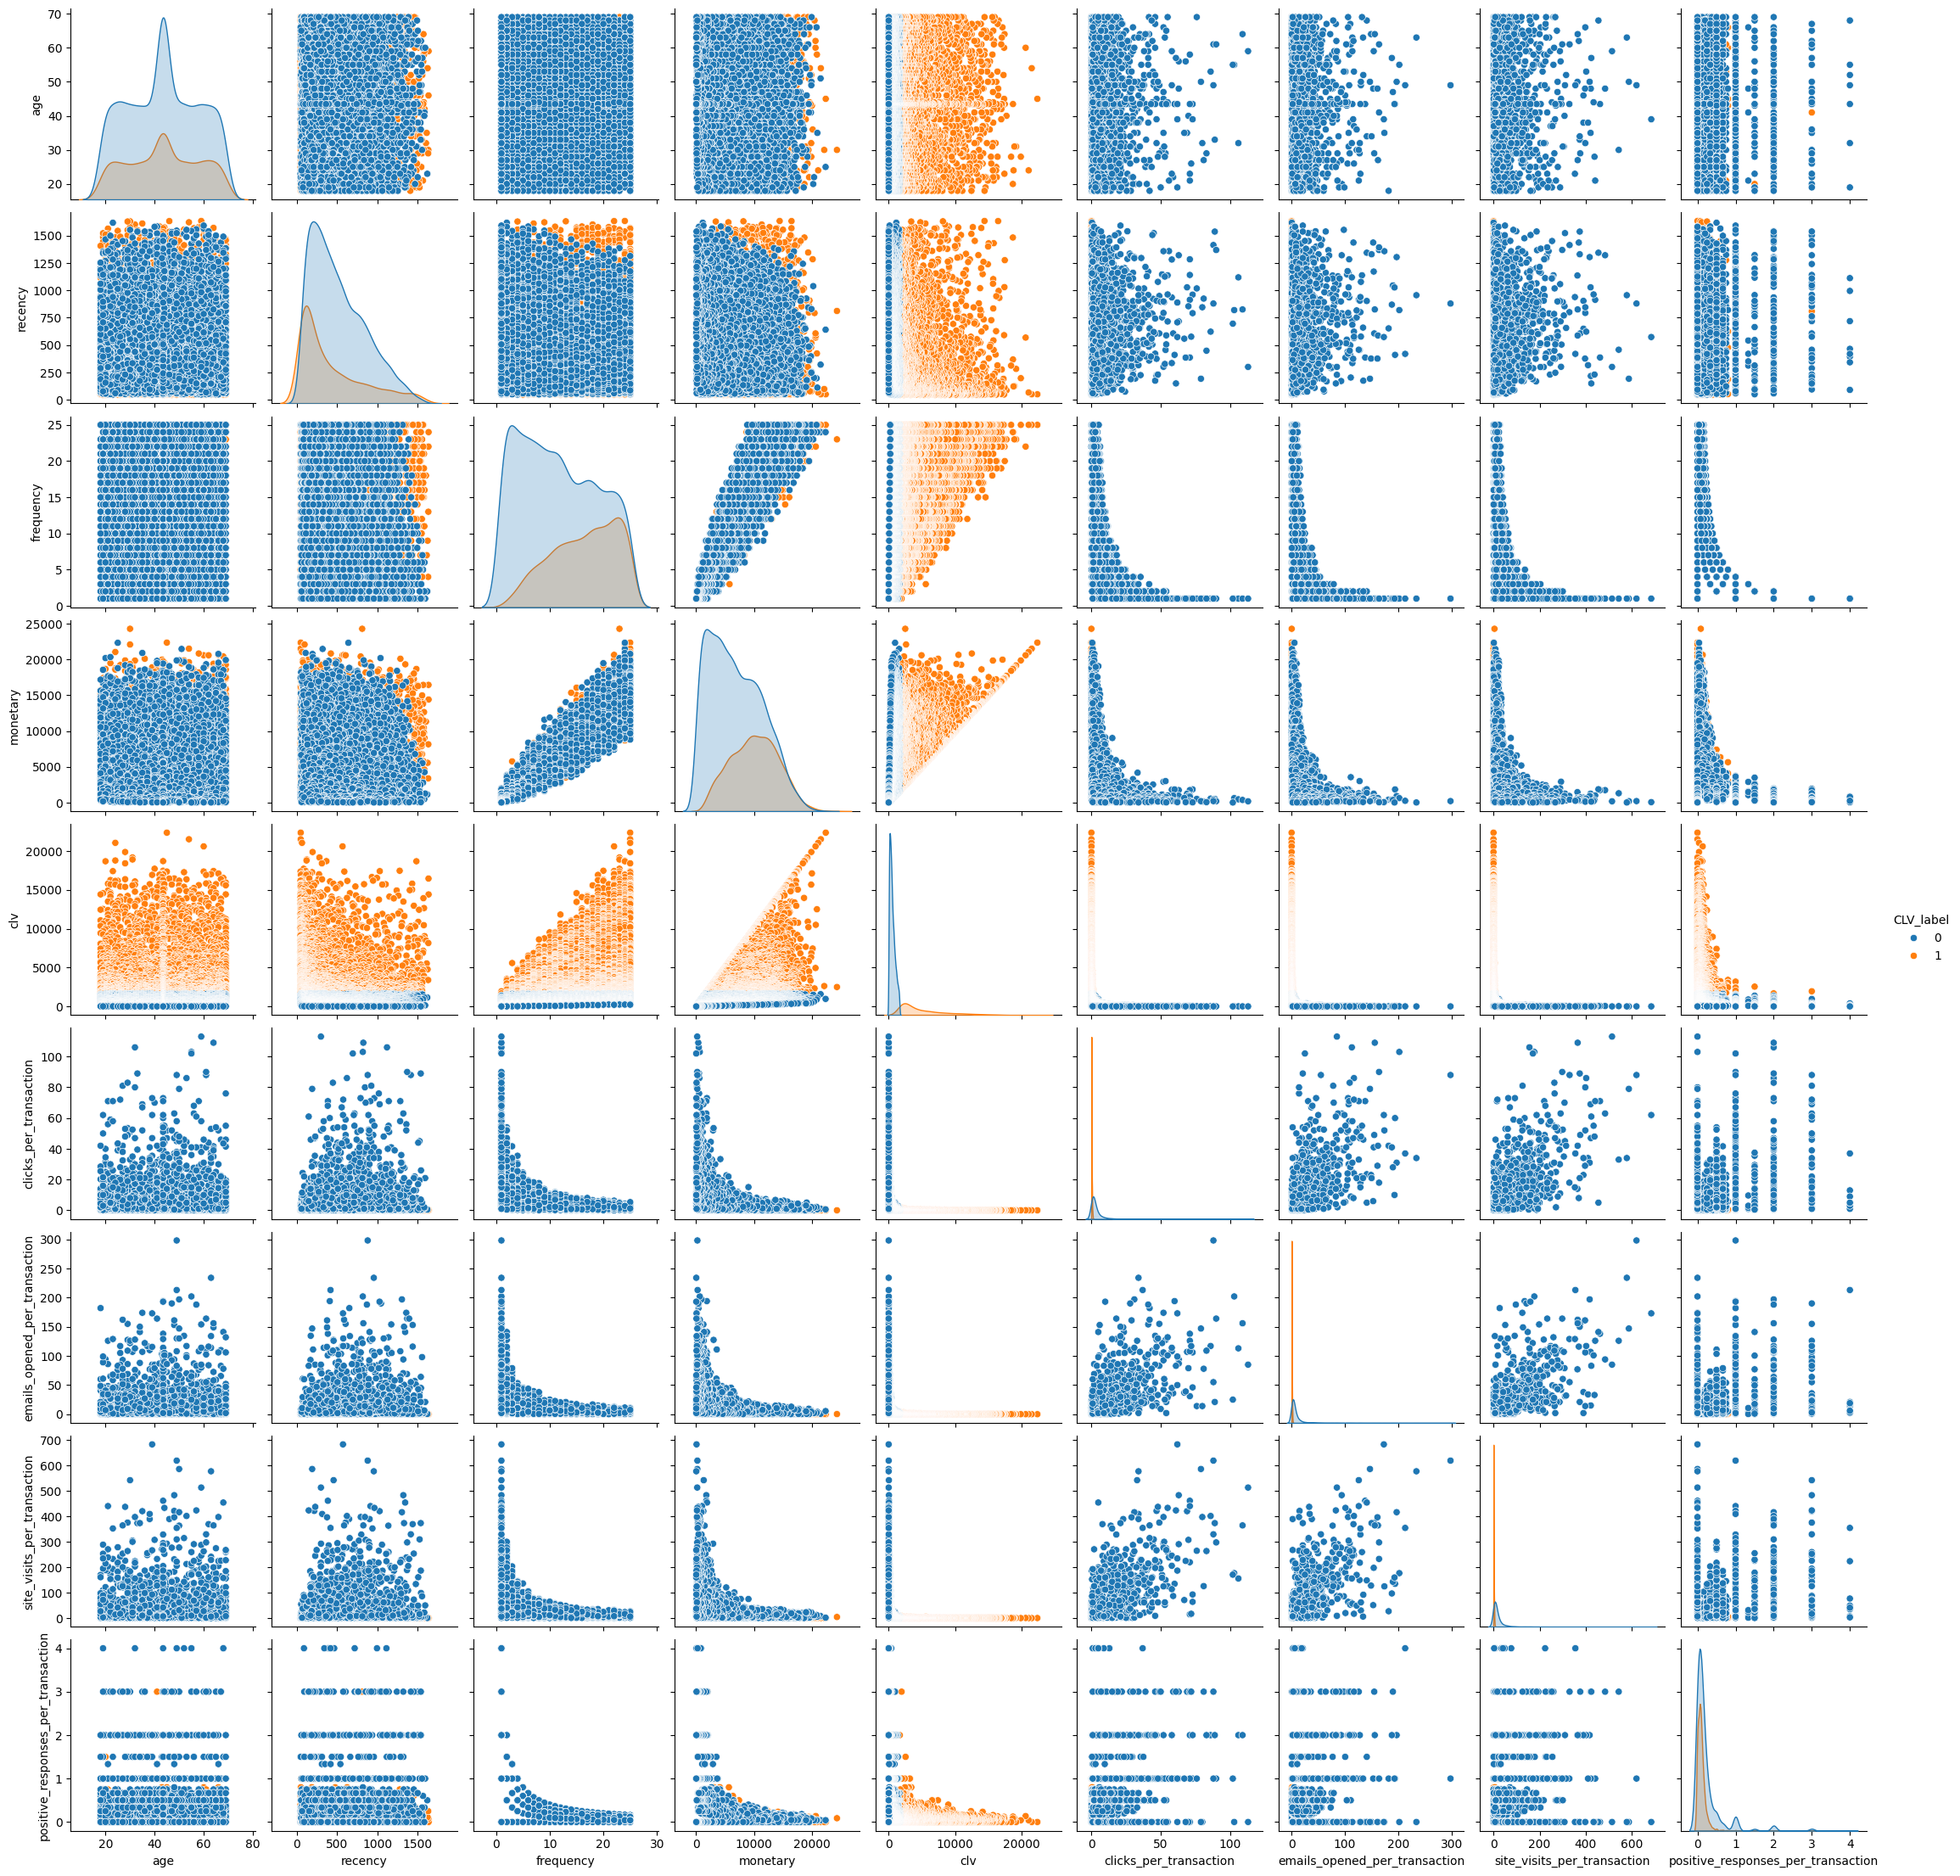

In [99]:
# Define the relevant features for the pairplot
features = [
    'age', 'recency', 'frequency', 'monetary', 'clv', 'CLV_label',
    'clicks_per_transaction', 'emails_opened_per_transaction',
    'site_visits_per_transaction', 'positive_responses_per_transaction'
]

# Create the pairplot
sns.pairplot(merged_df[features], hue='CLV_label')
plt.show()

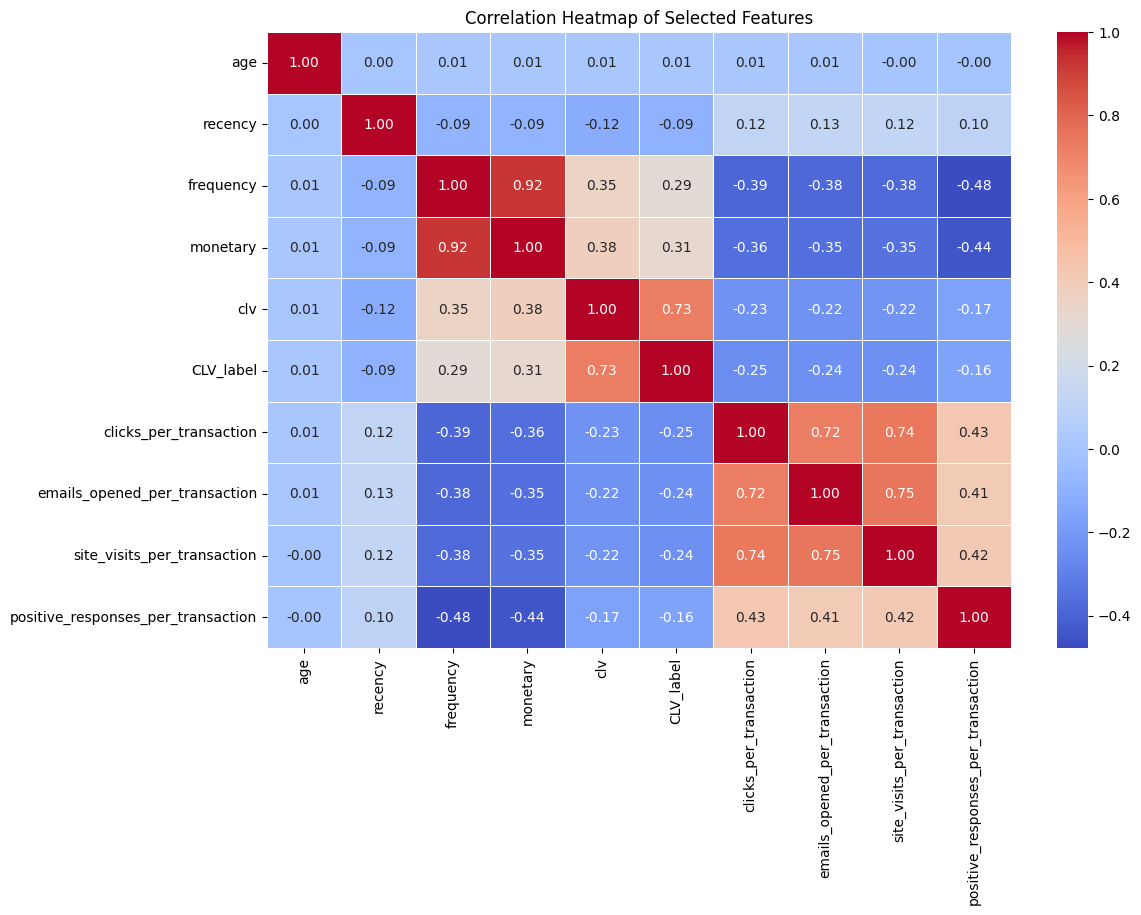

In [100]:
# Define the relevant features for the heatmap
features = [
    'age', 'recency', 'frequency', 'monetary', 'clv', 'CLV_label',
    'clicks_per_transaction', 'emails_opened_per_transaction',
    'site_visits_per_transaction', 'positive_responses_per_transaction'
]

# Calculate the correlation matrix
correlation_matrix = merged_df[features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

In [101]:
# Check the imbalance
# Calculate the distribution of the target variable
class_distribution = merged_df['CLV_label'].value_counts(normalize=True)

# Print the class distribution
print(class_distribution)

CLV_label
0    0.7155
1    0.2845
Name: proportion, dtype: float64


C:\Users\NeilXu\AppData\Local\Temp\ipykernel_20876\3934539645.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Customer Type', y='Average CLV', data=clv_comparison_df, palette='viridis')


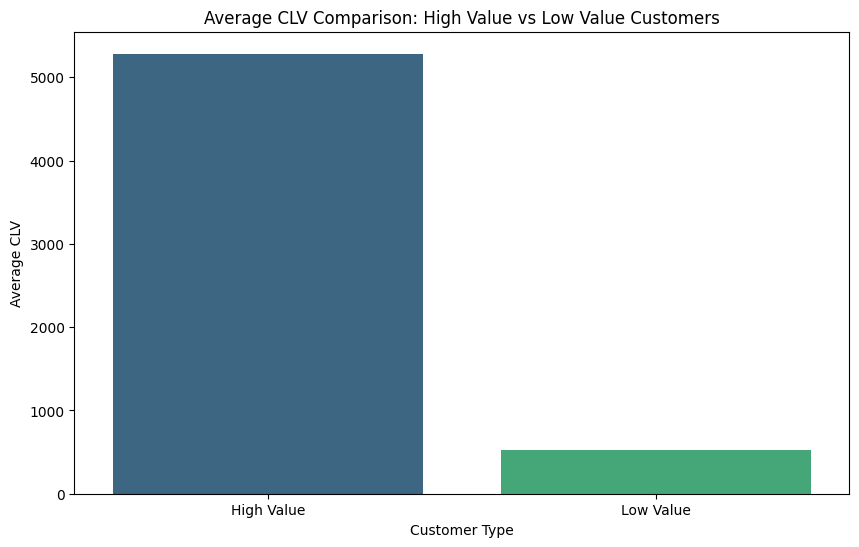

Average CLV of High Value Customers: $5282.23
Average CLV of Low Value Customers: $525.32


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average CLV for high-value and low-value customers
average_clv_high_value = merged_df[merged_df['CLV_label'] == 1]['clv'].mean()
average_clv_low_value = merged_df[merged_df['CLV_label'] == 0]['clv'].mean()

# Create a DataFrame to store the results for visualization
clv_comparison_df = pd.DataFrame({
    'Customer Type': ['High Value', 'Low Value'],
    'Average CLV': [average_clv_high_value, average_clv_low_value]
})

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Customer Type', y='Average CLV', data=clv_comparison_df, palette='viridis')
plt.title('Average CLV Comparison: High Value vs Low Value Customers')
plt.xlabel('Customer Type')
plt.ylabel('Average CLV')
plt.show()

# Display the calculated average CLVs
print(f"Average CLV of High Value Customers: ${average_clv_high_value:.2f}")
print(f"Average CLV of Low Value Customers: ${average_clv_low_value:.2f}")

    Promotion Type   CLV Label  Positive Response Rate
0  Buy One Get One   Low Value                0.501239
1  Buy One Get One  High Value                0.511598
2         Discount   Low Value                0.492710
3         Discount  High Value                0.492481
4    Free Shipping   Low Value                0.497231
5    Free Shipping  High Value                0.509000


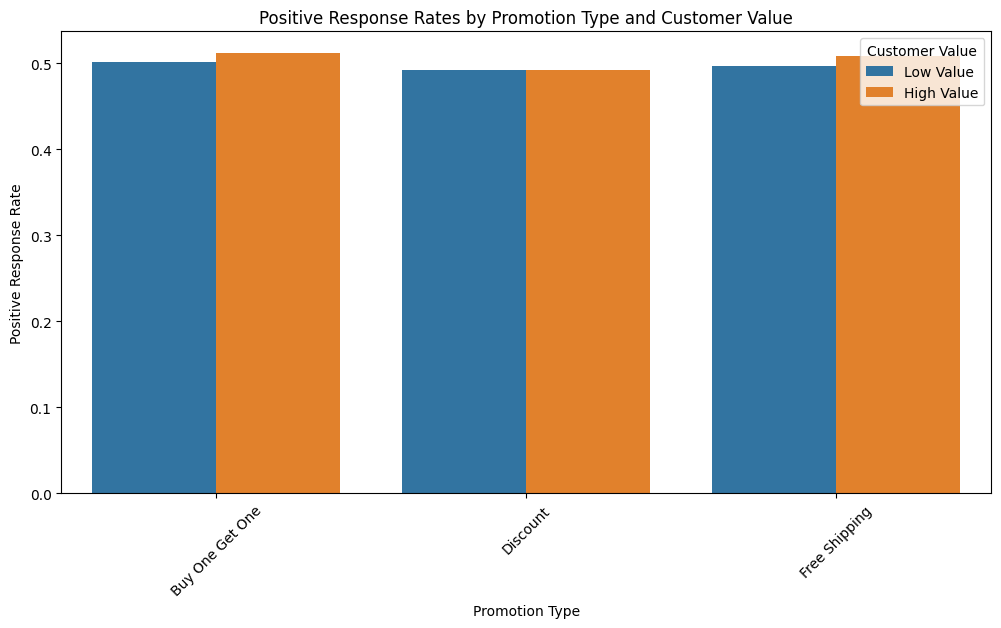

In [103]:
# Merge marketing data with CLV labels from merged_df
marketing_merged_df = marketing_df.merge(merged_df[['customer_id', 'CLV_label']], on='customer_id', how='left')

# Calculate positive response rates for each promotion type, differentiated by CLV label
positive_response_rates = marketing_merged_df.groupby(['promotion_type', 'CLV_label'])['response'].apply(lambda x: (x == 'Yes').mean()).reset_index()

# Rename columns for better readability
positive_response_rates.columns = ['Promotion Type', 'CLV Label', 'Positive Response Rate']

# Convert CLV Label to categorical labels
positive_response_rates['CLV Label'] = positive_response_rates['CLV Label'].replace({1: 'High Value', 0: 'Low Value'})

# Print the positive response rates
print(positive_response_rates)

# Visualize the positive response rates using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=positive_response_rates, x='Promotion Type', y='Positive Response Rate', hue='CLV Label')
plt.title('Positive Response Rates by Promotion Type and Customer Value')
plt.xlabel('Promotion Type')
plt.ylabel('Positive Response Rate')
plt.legend(title='Customer Value')
plt.xticks(rotation=45)
plt.show()

  Product Category   CLV Label  Average Transaction Amount
0         Clothing   Low Value                  253.650433
1         Clothing  High Value                  256.008964
2      Electronics   Low Value                 1011.962338
3      Electronics  High Value                 1044.121118
4       Home Goods   Low Value                  506.851489
5       Home Goods  High Value                  517.200171


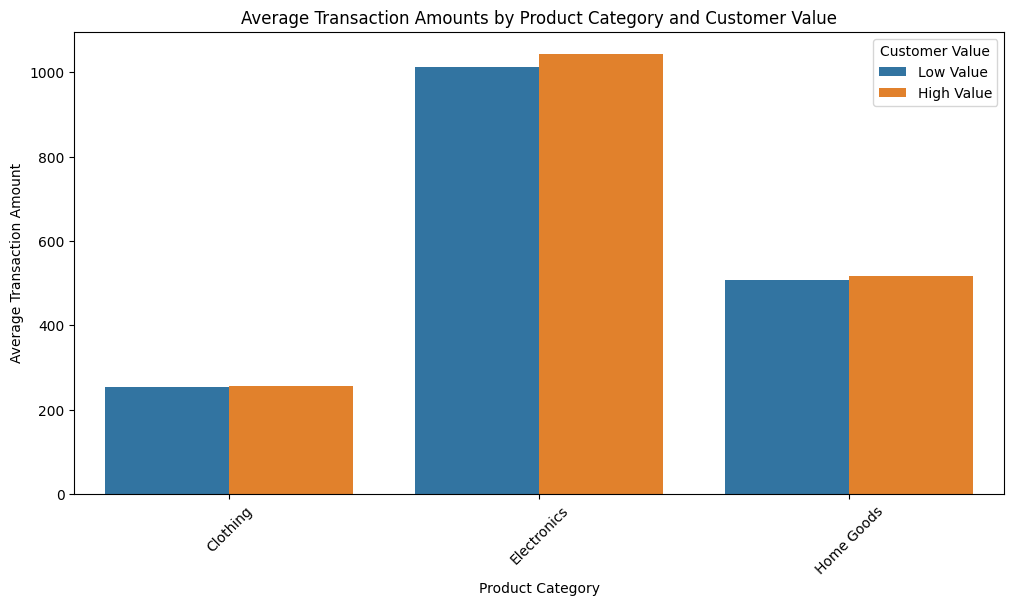

In [104]:
# Merge transactions data with CLV labels from merged_df
transactions_merged_df = transactions_df.merge(merged_df[['customer_id', 'CLV_label']], on='customer_id', how='left')

# Calculate average transaction amounts for each product category, differentiated by CLV label
avg_transaction_amounts = transactions_merged_df.groupby(['product_category', 'CLV_label'])['transaction_amount'].mean().reset_index()

# Rename columns for better readability
avg_transaction_amounts.columns = ['Product Category', 'CLV Label', 'Average Transaction Amount']

# Convert CLV Label to categorical labels
avg_transaction_amounts['CLV Label'] = avg_transaction_amounts['CLV Label'].replace({1: 'High Value', 0: 'Low Value'})

# Print the average transaction amounts
print(avg_transaction_amounts)

# Visualize the average transaction amounts using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_transaction_amounts, x='Product Category', y='Average Transaction Amount', hue='CLV Label')
plt.title('Average Transaction Amounts by Product Category and Customer Value')
plt.xlabel('Product Category')
plt.ylabel('Average Transaction Amount')
plt.legend(title='Customer Value')
plt.xticks(rotation=45)
plt.show()

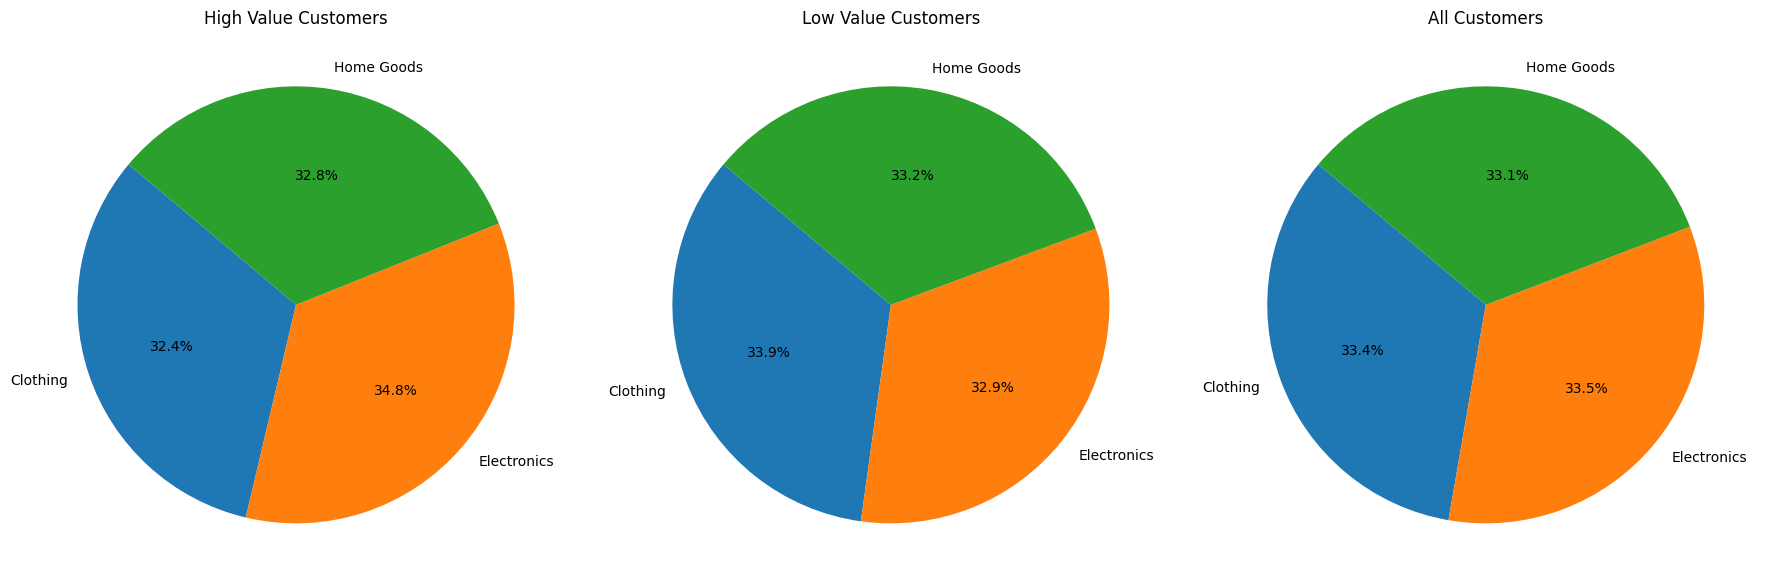

In [105]:
# Merge transactions data with CLV labels from merged_df
transactions_merged_df = transactions_df.merge(merged_df[['customer_id', 'CLV_label']], on='customer_id', how='left')

# Calculate transaction counts for each product category
transaction_counts = transactions_merged_df.groupby(['product_category', 'CLV_label']).size().reset_index(name='transaction_count')

# Calculate total transaction counts for all customers
total_transaction_counts = transactions_merged_df.groupby('product_category').size().reset_index(name='transaction_count')
total_transaction_counts['CLV_label'] = 'All Customers'

# Append total transaction counts to the transaction_counts dataframe
transaction_counts = pd.concat([transaction_counts, total_transaction_counts], axis=0)

# Calculate percentages
transaction_counts['percentage'] = transaction_counts.groupby('CLV_label')['transaction_count'].transform(lambda x: x / x.sum() * 100)

# Separate data for visualization
high_value_counts = transaction_counts[transaction_counts['CLV_label'] == 1]
low_value_counts = transaction_counts[transaction_counts['CLV_label'] == 0]
all_customers_counts = transaction_counts[transaction_counts['CLV_label'] == 'All Customers']

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# High Value Customers
axes[0].pie(high_value_counts['percentage'], labels=high_value_counts['product_category'], autopct='%1.1f%%', startangle=140)
axes[0].set_title('High Value Customers')

# Low Value Customers
axes[1].pie(low_value_counts['percentage'], labels=low_value_counts['product_category'], autopct='%1.1f%%', startangle=140)
axes[1].set_title('Low Value Customers')

# All Customers
axes[2].pie(all_customers_counts['percentage'], labels=all_customers_counts['product_category'], autopct='%1.1f%%', startangle=140)
axes[2].set_title('All Customers')

plt.tight_layout()
plt.show()